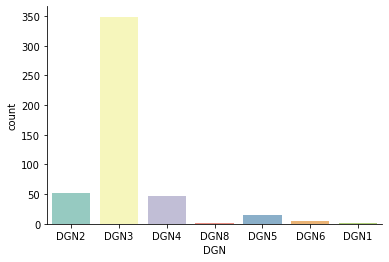

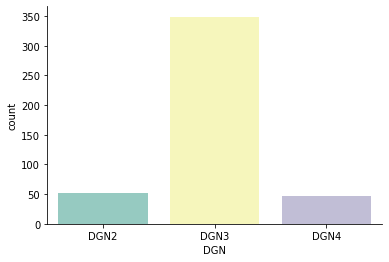

In [1]:
%run 'preprocessing/preprocessing_v1.1.ipynb'

In [272]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np 
import pandas as pd
import seaborn as sns 
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # for gradient warning (variables are still updated, therefore supressing is fine)
import tensorflow_probability as tfp 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.losses import Loss
import scipy

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

color_list = ['#bcad', '#dacb']

### Define prior distribution

In [4]:
def get_prior(num_modes, latent_dim):
    
    mixture_distribution = tfd.Categorical(probs=[1./num_modes] * num_modes)
    components_distribution = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal((num_modes, latent_dim))),
                                                        scale_diag=tfp.util.TransformedVariable(tf.ones((num_modes,latent_dim)),
                                                                                               bijector=tfb.Softplus())
                                                        )
    prior = tfd.MixtureSameFamily(mixture_distribution,
                                  components_distribution
                                 )
    return prior

In [5]:
latent_dim = 2
input_shape = 2

prior = get_prior(num_modes=latent_dim, latent_dim=input_shape) 
print(f'Prior event shape: {prior.event_shape[0]}')
print(f'# of Gaussions: {prior.components_distribution.batch_shape[0]}') 
print(f'Covariance matrix: {prior.components_distribution.name}')

Prior event shape: 2
# of Gaussions: 2
Covariance matrix: MultivariateNormalDiag


### Define KL divergence

In [6]:
# set weight for more emphasis on KLDivergence term rather than reconstruction loss
# average over both samples and batches

def get_KL_regularizer(prior, weight=4.):
    
    regularizer = tfpl.KLDivergenceRegularizer(prior, 
                                        use_exact_kl=False,
                                        test_points_reduce_axis=(),
                                        test_points_fn=lambda q: q.sample(10),
                                        weight=weight
                                        )
    return regularizer

In [7]:
KLDivergence_regularizer = get_KL_regularizer(prior)

### Define the encoder

In [8]:
def get_encoder(input_shape, latent_dim, KL_regularizer):
    
    encoder = Sequential([
        Dense(input_shape=input_shape, units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, 
                                   activity_regularizer=KL_regularizer),
    ])
    
    return encoder

In [9]:
encoder = get_encoder(input_shape=(input_shape,), latent_dim=latent_dim, KL_regularizer=KLDivergence_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8         
Total params: 44,173
Trainable params: 44,173
Non-trainable params: 0
____________________________________________________

### Define the decoder 

In [10]:
def get_decoder(latent_dim):
    
    decoder = Sequential([
        Dense(input_shape=(latent_dim,), units=5, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim)
    ])
    
    return decoder

In [11]:
decoder = get_decoder(latent_dim)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
_________________________________________________________________
multivariate_normal_tri_l_1  multiple                  0         
Total params: 43,028
Trainable params: 43,028
Non-trainable params: 0
__________________________________________________

### Connect encoder to decoder 

In [12]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8     

### Specify the loss function 

In [13]:
# KL divergence is implicity incorporated to the loss function before
# add reconstruction error to loss function 
def reconstruction_error(decoding_dist, x_true):
    return -tf.reduce_mean(decoding_dist.log_prob(x_true))

class custom_reconstruction_error(Loss):
    def call(self, decoding_dist, x_true):
        return -tf.reduce_mean(decoding_dist.log_prob(x_true))

### Selection process

In [14]:
print(f'# of training samples: {X_train.shape[0]}')
print(f'# of test samples: {X_test.shape[0]}')

# of training samples: 300
# of test samples: 148


In [15]:
X_train_prior = np.append(X_train.DGN.to_numpy().reshape(-1,1), scaler.inverse_transform(X_train[keepdims[1:]]), axis=1)
X_test_prior = np.append(X_test.DGN.to_numpy().reshape(-1,1), scaler.inverse_transform(X_test[keepdims[1:]]), axis=1)

In [16]:
X_train_prior_visual = pd.DataFrame(X_train_prior, columns=keepdims)
y_train.reset_index(drop=True, inplace=True)
X_train_prior_visual['Risk1Yr'] = y_train

In [17]:
X_train_prior_visual[keepdims[1:]] = X_train_prior_visual[keepdims[1:]].astype(np.float32)

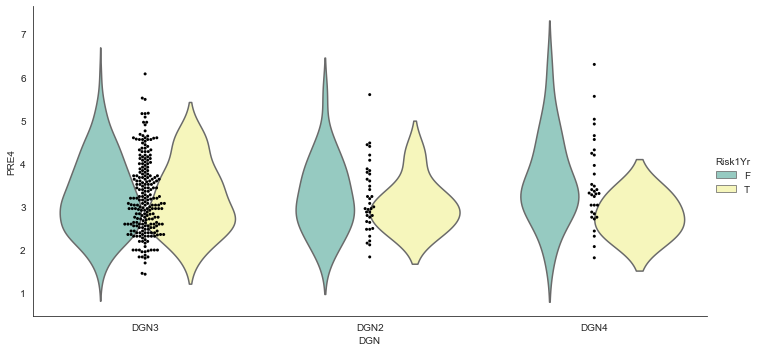

In [18]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_prior_visual, inner=None, legend_out=True, doge=True, palette='Set3', aspect=2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_prior_visual, ax=g.ax)
sns.despine()

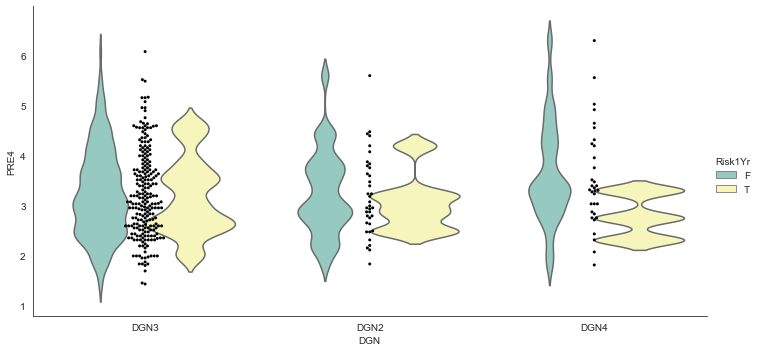

In [19]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_prior_visual, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_prior_visual, ax=g.ax)
sns.despine()

### Compile and fit the model 

In [20]:
X_train[keepdims[1:]] = X_train[keepdims[1:]].astype(np.float32)
X_test[keepdims[1:]] = X_test[keepdims[1:]].astype(np.float32)

In [21]:
X_train.drop('DGN',axis=1,inplace=True)
X_test.drop('DGN',axis=1,inplace=True)

In [22]:
optimizer = Adam(learning_rate=3e-4)
epochs = 600 
epoch_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print('\n Epoch {}/{}'.format(epoch+1, epochs, logs),
                                                                       '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                if epoch % 100 == 0 else False
                               )


vae.compile(optimizer=optimizer, loss=reconstruction_error)
history = vae.fit(X_train, 
                  validation_data=(X_test,),
                  epochs=epochs, 
                  batch_size=32,
                  verbose=0,
                  shuffle=True,
                  callbacks=[epoch_callback]
                 )


 Epoch 1/600 
	 loss: 66.8471, val_loss: 61.2101

 Epoch 101/600 
	 loss: 1.1517, val_loss: 0.9527

 Epoch 201/600 
	 loss: 0.3303, val_loss: 0.5014

 Epoch 301/600 
	 loss: 0.1722, val_loss: 0.0952

 Epoch 401/600 
	 loss: 0.1961, val_loss: 0.2668

 Epoch 501/600 
	 loss: 0.1852, val_loss: 0.1017


### Plot training and validation losses 

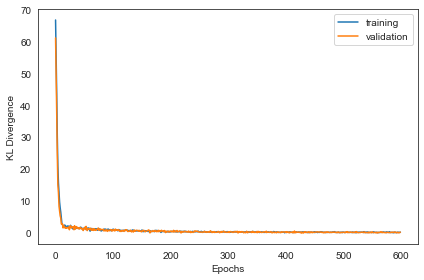

In [23]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.tight_layout()
plt.show()

# Loss function is ELBO maximization
# ELBO maximization is equivalent to KL divergence minimization 

### Sample from the generative model

In [24]:
X_train_sample = encoder(X_train.to_numpy()).sample()
X_train_sample = pd.DataFrame(X_train_sample.numpy(), columns=X_test.columns)

In [25]:
X_train_sample.head()

,PRE4,PRE5
0,0.989546,0.769618
1,-1.141636,-1.782783
2,0.292686,-2.235727
3,-2.091507,-0.520756
4,-1.748251,-3.229904


In [26]:
# propogate back from the pipeline
# training data -- reverse standardization

X_train_sample = pd.DataFrame(scaler.inverse_transform(X_train_sample.to_numpy()), columns=X_train.columns)
X_train_sample.head()

,PRE4,PRE5
0,4.136053,14.407845
1,2.266171,-17.389235
2,3.524633,-23.031879
3,1.432762,-1.667262
4,1.733932,-35.417049


In [27]:
# propogate back from the pipeline
# testing data -- reverse standardization

X_test_sample = encoder(X_test.to_numpy()).sample()
X_test_sample = pd.DataFrame(X_test_sample.numpy(), columns=X_test.columns)

X_test_sample = pd.DataFrame(scaler.inverse_transform(X_test_sample.to_numpy()), columns=X_test.columns)
X_test_sample.head()

,PRE4,PRE5
0,2.802046,3.625499
1,3.572150,-14.412976
2,2.175541,-23.002007
3,2.628250,2.791252
4,0.684690,0.722827


In [28]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True) # for concatenation

X_train_sample['Risk1Yr'] = y_train
X_train_sample['DGN'] = X_train_prior[...,0]

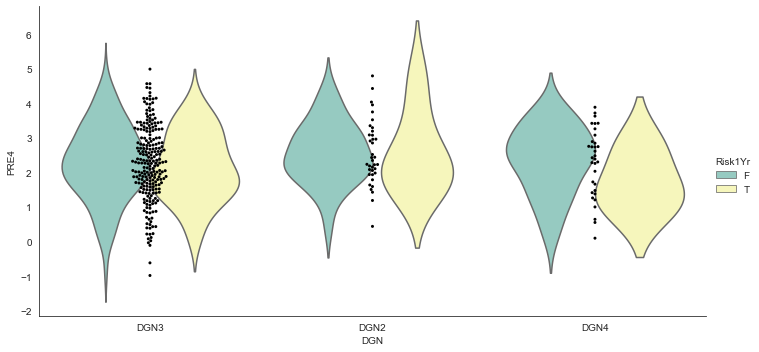

In [29]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_sample, inner=None, legend_out=True, doge=True, palette='Set3', aspect=2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_sample, ax=g.ax)
sns.despine()

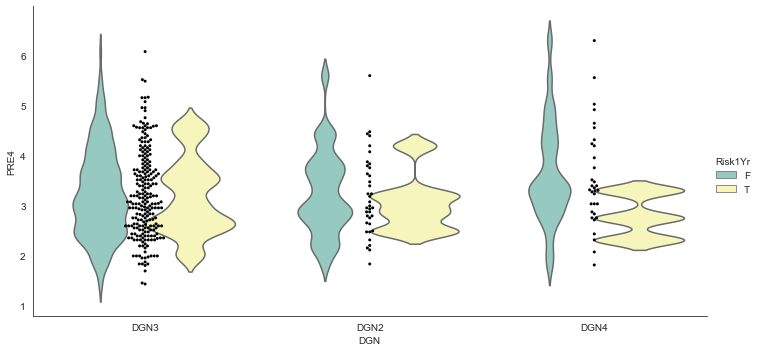

In [79]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_prior_visual, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
f = sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_prior_visual, ax=g.ax)
sns.despine()
f = f.get_figure()
f.savefig(os.getcwd() + '/maf-results/prior.jpeg')

In [36]:
# decode 
X_train_sample.drop('Risk1Yr',axis=1,inplace=True)
X_train_sample.drop('DGN', axis=1, inplace=True)
X_train_sample = pd.DataFrame(scaler.inverse_transform(decoder(X_train_sample.to_numpy()).sample().numpy()), columns=X_train.columns)
X_train_sample.head()

,PRE4,PRE5
0,4.116869,2.669648
1,5.254632,-21.859900
2,3.928392,-4.314292
3,4.634228,-16.521246
4,3.502081,11.689262


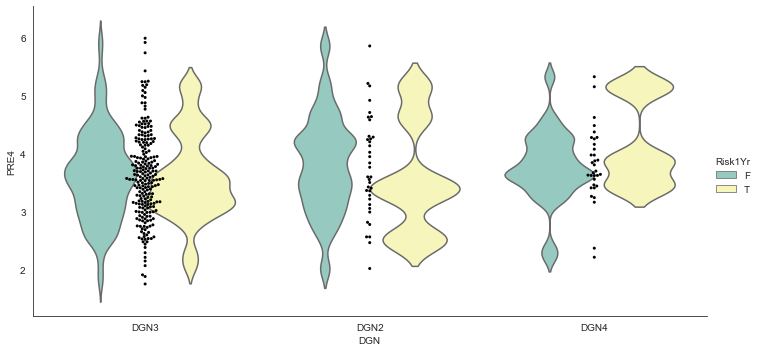

In [37]:
X_train_sample['DGN'] = X_train_prior[...,0]
X_train_sample['Risk1Yr'] = y_train

g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_sample, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_sample, ax=g.ax)
sns.despine()

### Masked Autoregressive Flow

In [38]:
X_train_sample.drop('Risk1Yr', axis=1, inplace=True) # drop target, was only intended for VAE sampling

In [39]:
loc = [X_train_sample[i].mean().astype('float32') for i in list(X_train.columns)]
scale_diag = [X_train_sample[i].std().astype('float32') for i in list(X_train.columns)]

In [40]:
mvn = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [41]:
def masked_autoregressive_flow(hidden_units=[16,16], event_shape=[2], activation='relu'):
    network = tfb.AutoregressiveNetwork(params=2, 
                                    hidden_units=hidden_units,
                                    event_shape=event_shape,
                                    activation=activation
                                   )
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=network)

In [42]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                             bijector=masked_autoregressive_flow(
                                             activation='sigmoid'))
trainable_dist

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [43]:
n_samples = 300
x = mvn.sample(sample_shape=n_samples)
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

In [44]:
X_train_np = X_train_sample.to_numpy()
X_test_np = X_test_sample.to_numpy()

In [45]:
X_train_np = X_train_np[:,0:2]
X_test_np = X_test_np[:,0:2]

In [46]:
# standardize once again before feeding into network 
scaler.fit(X_train_np)
X_train_np = scaler.transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

In [47]:
X_train = X_train_np.astype(np.float32)
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_train = X_train.batch(32)

X_valid = X_test_np.astype(np.float32)
X_valid = tf.data.Dataset.from_tensor_slices(X_valid)
X_valid = X_valid.batch(32)

In [48]:
num_epochs = 600
opt = tf.keras.optimizers.Adam(3e-4)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 100...
Epoch 200...
Epoch 300...
Epoch 400...
Epoch 500...


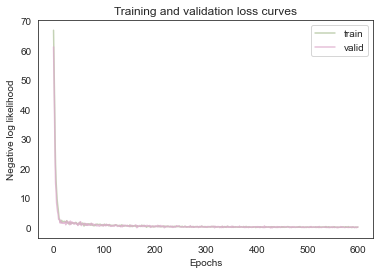

In [49]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train', c=color_list[0])
plt.plot(valid_losses, label='valid', c=color_list[1])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [50]:
x = mvn.sample(sample_shape=n_samples)
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

In [51]:
num_layers = 4
flow_bijector = []

# set trainable=False for once and for all initialization 
def init_once(x):
    return tf.Variable(x, name='permutation', trainable=False)


for i in range(num_layers):
    flow_i = masked_autoregressive_flow(hidden_units=[256,256])
    flow_bijector.append(flow_i) 
    flow_bijector.append(tfb.Permute(init_once(x=np.random.permutation(2).astype('int64'))))
# discard the last permute layer 
flow_bijector = tfb.Chain(list(reversed(flow_bijector[:-1])))

In [52]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                            bijector=flow_bijector)
trainable_dist

<tfp.distributions.TransformedDistribution 'chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [54]:
def make_samples():
    x = mvn.sample(n_samples)
    samples = [x]
    names = [mvn.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

In [55]:
num_epochs = 600
opt = tf.keras.optimizers.Adam(3e-4)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 100...
Epoch 200...
Epoch 300...
Epoch 400...
Epoch 500...


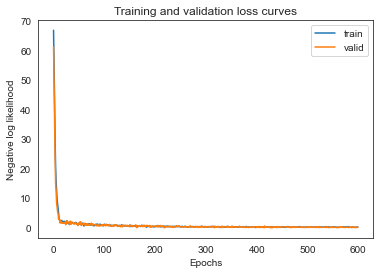

In [56]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [57]:
names, samples = make_samples()

In [232]:
def visualize_training_data(samples, plot_color: str=color_list[0]):
    f, arr = plt.subplots(1, 2, figsize=(20,5))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_train_np), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color=plot_color)
        z = np.polyfit(X, Y, 1)
        p = np.poly1d(z)
        arr[i].plot(X, p(X), color=color_list[1])
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

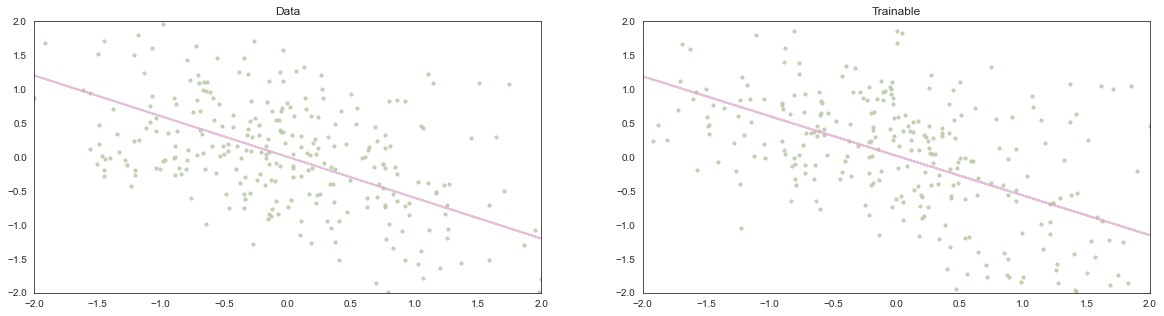

In [233]:
visualize_training_data(samples)
# learns the distribution perfectly

In [81]:
samples_nf = pd.DataFrame(scaler.inverse_transform(samples[-1].numpy()),columns=keepdims[1:])
samples_nf['Risk1Yr'] = y_train
samples_nf['DGN'] = X_train_sample.DGN

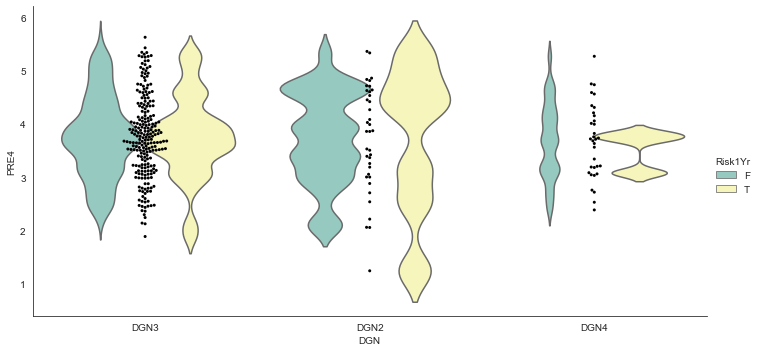

In [82]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=samples_nf, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
f = sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=samples_nf, ax=g.ax)
f = f.get_figure()
sns.despine()
f.savefig(os.getcwd() + '/maf-results/approx.jpeg')

### Measure KL Divergence 

In [221]:
# training 
prior_train = mvn.prob(X_train_np).numpy()
learned_train = trainable_dist.prob(X_train_np).numpy()

kl = tf.keras.metrics.KLDivergence()
kl.update_state(prior_train, learned_train)
print(kl.result().numpy())
kl.reset_state()

# testing
prior_test = mvn.prob(X_test_np).numpy()
learned_test = trainable_dist.prob(X_test_np).numpy()

kl = tf.keras.metrics.KLDivergence()
kl.update_state(prior_test, learned_test)
print(kl.result().numpy())
kl.reset_state()

-0.060796056
-0.0009700739


### Measure Shannon Entropy

In [222]:
# training
cross_entropy = prior_train * np.log(learned_train)
print(-np.ma.masked_invalid(cross_entropy).sum())

# testing
cross_entropy = prior_test * np.log(learned_test)
print(-np.ma.masked_invalid(cross_entropy).sum())

0.19786361
0.00043223737


### Measure Poisson 

In [225]:
# training 
poisson = tf.keras.metrics.Poisson()
poisson.update_state(prior_train, learned_train)
print(poisson.result().numpy())
poisson.reset_state()

# testing 
poisson = tf.keras.metrics.Poisson()
poisson.update_state(prior_test, learned_test)
print(poisson.result().numpy())
poisson.reset_state()

0.11741386
0.039691746


### Measure MAE

In [255]:
# training 
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(prior_train, learned_train).numpy())

# testing
print(mae(prior_test, learned_test).numpy())

0.11664913
0.039687928


### Performance Evaluation

In [328]:
# collect metrics
def _collect(prior_train, learned_train, prior_test, learned_test, results, number_of_run):
    
    kl = tf.keras.metrics.KLDivergence()
    # KL training
    kl.update_state(prior_train, learned_train)
    results['Kullback-Leibler Divergence'][number_of_run][0] = kl.result().numpy()
    kl.reset_state()
    # KL testing
    kl.update_state(prior_test, learned_test)
    results['Kullback-Leibler Divergence'][number_of_run][1] = kl.result().numpy()
    kl.reset_state()
    
    # Cross Entropy training
    results['Cross Entropy'][number_of_run][0] = -np.ma.masked_invalid(prior_train * np.log(learned_train)).sum()
    # Cross Entropy testing
    results['Cross Entropy'][number_of_run][1] = -np.ma.masked_invalid(prior_test * np.log(learned_test)).sum()
    
    poisson = tf.keras.metrics.Poisson()
    # Poisson training
    poisson.update_state(prior_train, learned_train)
    results['Poisson'][number_of_run][0]  = poisson.result().numpy()
    poisson.reset_state()
    # Poisson testing
    poisson.update_state(prior_test, learned_test)
    results['Poisson'][number_of_run][1]  = poisson.result().numpy()
    poisson.reset_state()
    
    # MAE training 
    mae = tf.keras.losses.MeanAbsoluteError()
    results['Mean Absolute Error'][number_of_run][0] = mae(prior_train, learned_train).numpy()
    results['Mean Absolute Error'][number_of_run][1] = mae(prior_test, learned_test).numpy()
    
    return results 

NUMBER_OF_RUNS = 5
# metrics to measure KL, Poisson, Cross Entropy, Mean Absolute Error
results = {'Kullback-Leibler Divergence': [[None, None] for _ in range(NUMBER_OF_RUNS)], 
          'Poisson': [[None, None] for _ in range(NUMBER_OF_RUNS)],
          'Cross Entropy': [[None, None] for _ in range(NUMBER_OF_RUNS)],
          'Mean Absolute Error': [[None, None] for _ in range(NUMBER_OF_RUNS)]
          }

# generate new observations and measure with the generative model 
def _results(X_train_np, X_test_np, NUMBER_OF_RUNS, results):
    for num in range(NUMBER_OF_RUNS):
        
        X_gen_train = encoder(X_train_np).sample().numpy()
        X_gen_test = encoder(X_test_np).sample().numpy()
        
        # convert arrays to probabilities for metric calculation, avoids nan or inf values
        X_gen_train = tf.exp(-X_gen_train) / tf.reduce_sum(tf.exp(-X_gen_train), axis=0)
        X_gen_test = tf.exp(-X_gen_test) / tf.reduce_sum(tf.exp(-X_gen_test), axis=0)
        
        # get distributions for train and test 
        prior_train = mvn.prob(X_gen_train).numpy()
        learned_train = trainable_dist.prob(X_gen_train).numpy()
        
        prior_test = mvn.prob(X_gen_test).numpy()
        learned_test = trainable_dist.prob(X_gen_test).numpy()
        
        results = _collect(prior_train, learned_train, prior_test, learned_test, results, num)
        
    return results

In [329]:
# convert output of encoder to probabilities 
trial_data = encoder(X_train_np).sample().numpy()
tf.reduce_sum(tf.exp(-trial_data) / tf.reduce_sum(tf.exp(-trial_data), axis=0),axis=0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.       , 1.0000002], dtype=float32)>

In [331]:
# sanity check 
_results(X_train_np, X_test_np, NUMBER_OF_RUNS, results)

{'Kullback-Leibler Divergence': [[-0.00046774241, -0.00023566157],
  [-0.0004676838, -0.00023601892],
  [-0.00046855563, -0.00023610488],
  [-0.00046779684, -0.00023584744],
  [-0.00046764978, -0.0002359211]],
 'Poisson': [[0.19686176, 0.19799596],
  [0.19687605, 0.19787571],
  [0.19683719, 0.19787547],
  [0.19684102, 0.19783667],
  [0.1968755, 0.19782776]],
 'Cross Entropy': [[5.273578e-05, 2.650485e-05],
  [5.272616e-05, 2.6554939e-05],
  [5.283056e-05, 2.65651e-05],
  [5.274579e-05, 2.6539747e-05],
  [5.2722895e-05, 2.6549602e-05]],
 'Mean Absolute Error': [[0.19686148, 0.19799566],
  [0.19687577, 0.19787541],
  [0.1968369, 0.19787519],
  [0.19684075, 0.19783638],
  [0.19687521, 0.19782746]]}

In [333]:
NUMBER_OF_RUNS = 10000
# TODO: measure confidence intervals, p-values